# Сборный проект — 2

**Цель работы**: подготовить 2 модели машинного обучения, способные решить поставленные перед HR-аналитиками задачи

<a id="info"></a> 
## Информация о данных

id — уникальный идентификатор сотрудника;

dept — отдел, в котором работает сотрудник;

level — уровень занимаемой должности;

workload — уровень загруженности сотрудника;

employment_years — длительность работы в компании (в годах);

last_year_promo — показывает, было ли повышение за последний год;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

salary — ежемесячная зарплата сотрудника;

job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании(целевой признак первой задачи);

quit - увольнение сотрудника из компании(целевой признак второй задачи);

In [1]:
!pip install matplotlib==3.5.0
!pip install shap -q
!pip install phik -q
!pip install -U scikit-learn -q

import pandas as pd
import numpy as np

from random import randint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.feature_selection import SelectKBest, f_classif

import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from IPython.display import display

from phik import phik_matrix

import shap

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="interval columns not set")

     |████████████████████████████████| 11.2 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 54.4 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 3.3 MB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 56.5 MB/s eta 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.6.0.post20210108
    Uninstalling setuptools-49.6.0.post20210108:
      Successfully uninstalled setuptools-49.6.0.post20210108
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4


<a id="t1"></a> 
## Предсказание уровня удовлетворённости сотрудника

<a id="t2_1"></a> 
### Загрузка данных

In [2]:
train_data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_data = pd.read_csv('/datasets/test_features.csv')
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

Посмотрим на данные и сделаем некоторы выводы

In [3]:
train_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Данные в таблице соответствуют описанию, однако в датасете присутствуют пропуски

In [5]:
test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Здесь данные тоже корректные и тоже имеют пропуски

In [7]:
test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Никаких проблем

<a id="downl1"></a> 
**В результате загрузки и первичного осмотра данных**:

- было обнаружены пропущенные значения в таблицах **train_data** и **test_data**
- опрделно, что признаки имеют корректные названия
- выявлено, что данные в таблицах соответствуют описанию

<a id="t2_2"></a> 
### Предобработка данных

Обновим таблицу test_data - добавим значение *job_satisfaction_rate* из **test_target**

In [9]:
test_data = test_data.merge(test_target, on='id')

<a id="t2_2_2"></a> 
#### Обработка дубликатов

Проверим данные на наличие явных дубликатов

In [10]:
train_data.duplicated().sum()

0

Дубликаты отстутствуют, однако что изменится при удалении признака *id*?

In [11]:
train_data.drop('id', axis=1).duplicated().sum()

245

Возможно, это всё сотрудники с одинаковыми значениями, однако их довольно-таки много. Дубликаты в тренировочной выборке не помемашют модели МО, так что оставим их, а столбец *id* сделаем индексом

In [12]:
train_data.set_index('id', inplace=True)
test_data.set_index('id', inplace=True)

Теперь посмотрим, нет ли в таблицах неявных дубликатов

In [13]:
for col in test_data.select_dtypes(include='object'):
    print(f' {col}: {test_data[col].unique()}\n')

 dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

 level: ['junior' 'middle' 'sinior' nan]

 workload: ['medium' 'low' 'high' ' ']

 last_year_promo: ['no' 'yes']

 last_year_violations: ['no' 'yes']



In [14]:
for col in train_data.select_dtypes(include='object'):
    print(f' {col}: {train_data[col].unique()}\n')

 dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

 level: ['junior' 'middle' 'sinior' nan]

 workload: ['medium' 'high' 'low']

 last_year_promo: ['no' 'yes']

 last_year_violations: ['no' 'yes']



Пока что не будем обращать внимание на пропуски, так как мы избавимся от них в шаге 5 в процессе работы с пайпланом

Как можено заметить, в таблице **test_data** присутствуют некорректные данные:

- в dept есть значение ' '(пробел),
- в level некорректно записано значение 'sinior',
- в workload присутствует значение ' '(пробел)

Обработаем некорректные данные

In [15]:
test_data.replace({' ': np.nan}, inplace=True)
test_data['level'].replace({'sinior': 'senior'}, inplace=True)
train_data['level'].replace({'sinior': 'senior'}, inplace=True)

**В результате предобработки данных**:

- в таблицу **test_data** добавлен целевой признак из test_target**
- заменены некорректные значения в таблице **test_data**

<a id="t2_3"></a> 
### Исследовательский анализ данных

Разделим количественные и категориальные признаки таблицы **train_data**

In [16]:
train_data_num_cols = ['salary', 'job_satisfaction_rate']
train_data_cat_cols = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
                       'last_year_violations', 'supervisor_evaluation'
                      ]

In [17]:
train_data.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


Посмотрим на распределение данных в количественных переменных на гистограммах

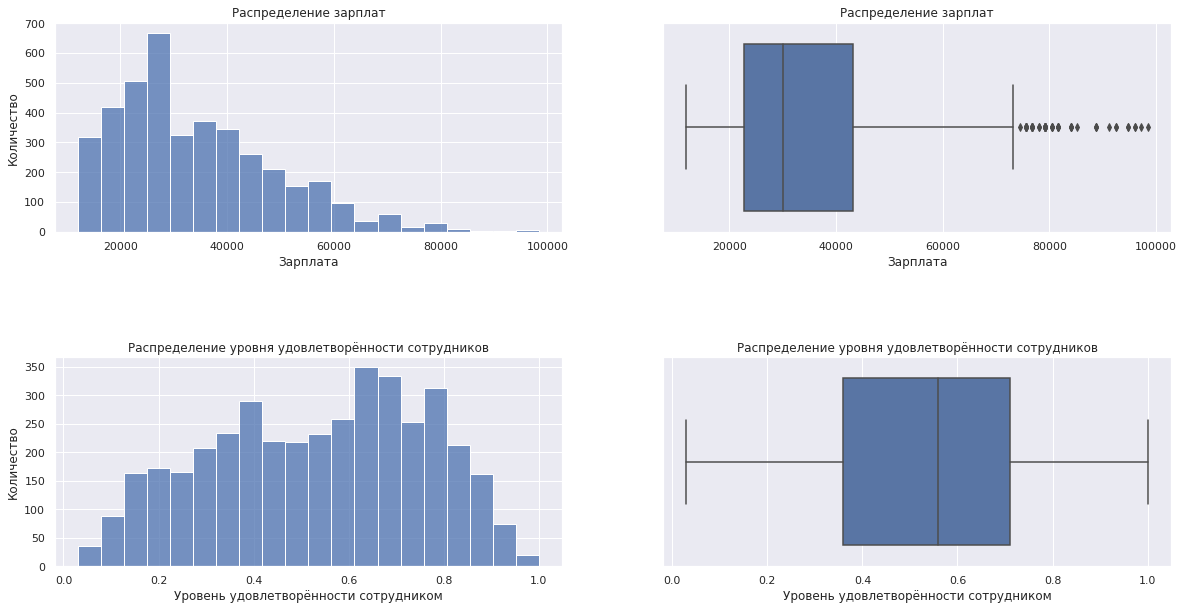

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# sns.histplot(data=prep_data, x='employment_years', bins=10, discrete=True, ax=axs[0, 0])
# axs[0,0].set_xlabel('Длительность работы в компании')
# axs[0,0].set_ylabel('Количество')
# axs[0,0].set_title('Распределение длительности работы')

# sns.boxplot(prep_data['employment_years'], orient='h', ax=axs[0, 1])
# axs[0,1].set_xlabel('Длительность работы в компании')
# axs[0,1].set_title('Распределение длительности работы')

# sns.histplot(data=prep_data, x='supervisor_evaluation', discrete=True, ax=axs[1, 0])
# axs[1,0].set_xlabel('Оценка сотрудника, данная руководителем')
# axs[1,0].set_ylabel('Количество')
# axs[1,0].set_title('Распределение оценок сотрудников')

# sns.boxplot(prep_data['supervisor_evaluation'], orient='h', ax=axs[1, 1])
# axs[1,1].set_xlabel('Оценка сотрудника, данная руководителем')
# axs[1,1].set_title('Распределение оценок сотрудников')

sns.histplot(data=train_data, x='salary', bins=20, ax=axs[0, 0])
axs[0,0].set_xlabel('Зарплата')
axs[0,0].set_ylabel('Количество')
axs[0,0].set_title('Распределение зарплат')

sns.boxplot(train_data['salary'], orient='h', ax=axs[0, 1])
axs[0,1].set_xlabel('Зарплата')
axs[0,1].set_title('Распределение зарплат')

sns.histplot(data=train_data, x='job_satisfaction_rate', bins=20, ax=axs[1, 0])
axs[1,0].set_xlabel('Уровень удовлетворённости сотрудником')
axs[1,0].set_ylabel('Количество')
axs[1,0].set_title('Распределение уровня удовлетворённости сотрудников')

sns.boxplot(train_data['job_satisfaction_rate'], orient='h', ax=axs[1, 1])
axs[1,1].set_xlabel('Уровень удовлетворённости сотрудником')
axs[1,1].set_title('Распределение уровня удовлетворённости сотрудников')

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show();

Что можно сказать, взглянув на эти графики:

- в количественных признаках отсутствуют аномальные значения,
- распределение значений признаков преимущественно нормальное

Теперь взглянем на категориальные признаки

In [19]:
def double_plots(u_data, cols, xlabels, titles, figsize):
    fig, axs = plt.subplots(len(cols), 2, figsize=figsize)
    for i in range(len(cols)):
        data = u_data[cols[i]].value_counts()
        
        axs[i, 0].bar(data.index, data)
        axs[i, 0].set_xlabel(xlabels[i])
        axs[i, 0].set_ylabel('Количество')
        axs[i, 0].set_title(titles[i])
        
        axs[i, 1].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
        axs[i, 1].set_xlabel(xlabels[i])
        axs[i, 1].set_title(titles[i])
        
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        
    plt.show();

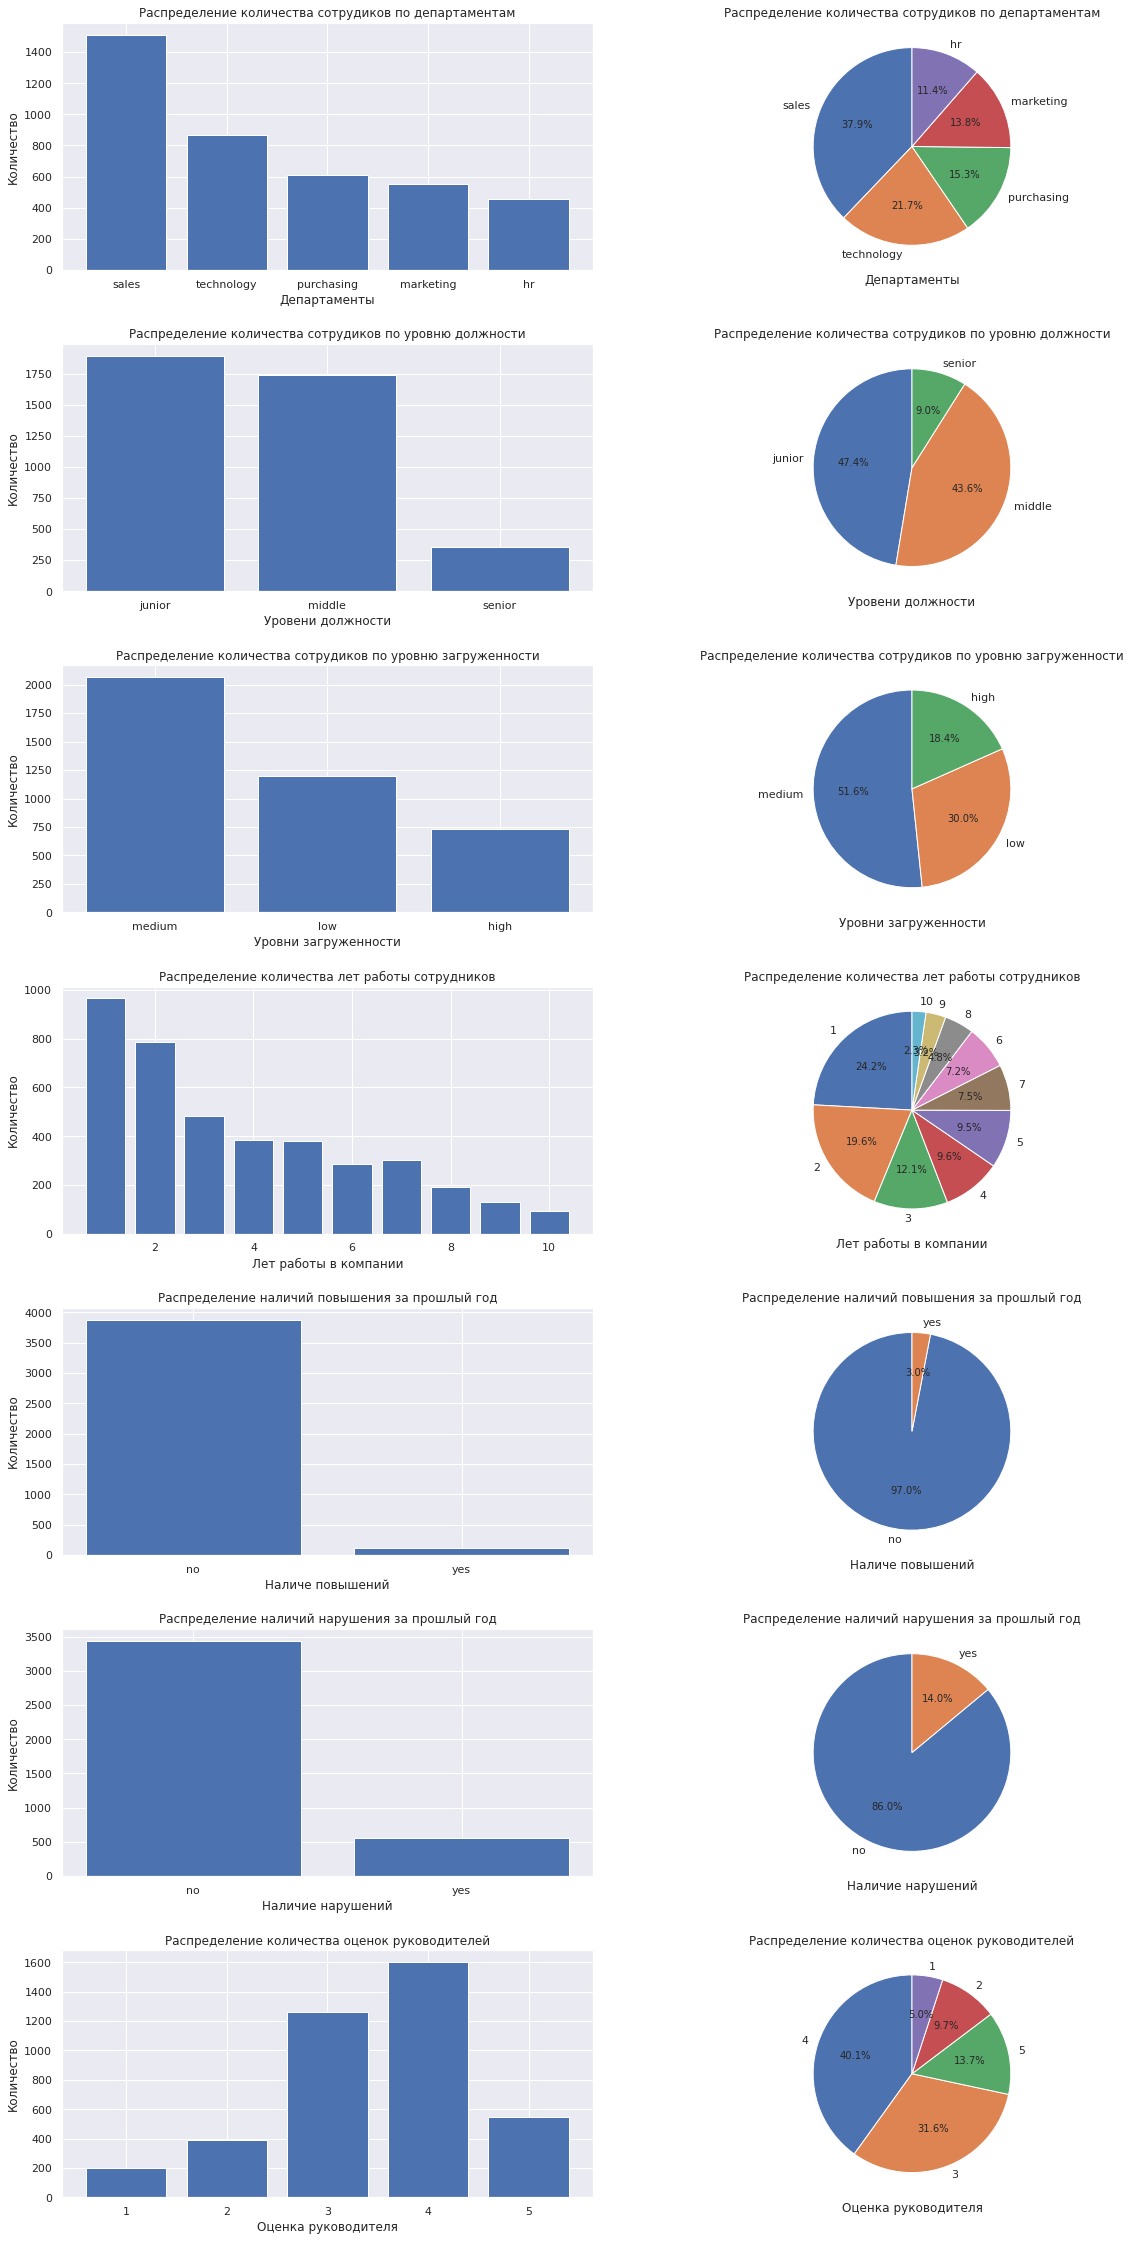

In [20]:
obj_pdata_titles = [
    'Распределение количества сотрудиков по департаментам',
    'Распределение количества сотрудиков по уровню должности',
    'Распределение количества сотрудиков по уровню загруженности',
    'Распределение количества лет работы сотрудников',
    'Распределение наличий повышения за прошлый год',
    'Распределение наличий нарушения за прошлый год',
    'Распределение количества оценок руководителей'
]

obj_pdata_xlabels = [
    'Департаменты',
    'Уровени должности',
    'Уровни загруженности',
    'Лет работы в компании',
    'Наличе повышений',
    'Наличие нарушений',
    'Оценка руководителя'
]

double_plots(train_data, train_data_cat_cols, obj_pdata_xlabels, obj_pdata_titles, (20, 40))

В этих данных также нет ничего аномального. Единственное - удивляет слишком малое количество повышений за год

Уже на этом этапе можно сказать, как будут подготавливаться данные для МО:

- все числовые признаки будут стандартизированы,
- *last_year_promo* и *last_year_volations* будут закодированы через OHE, так как они имеют всего 2 значения и не имеют внутреннего порядка,
- остальные категориальные признаки будут закодированы через OrdinalEncoder

<a id="an1"></a> 
**В ходе исследовательского анализа данных:**

- было графически предаставлено распределение значений признаков
- были выявлено отсутствие выбросов
- выявлено, что данные имеют преимущественно нормальное распределение
- определены способы подготовки данных

<a id="t2_4"></a> 
### Корреляционный анализ

Теперь узнаем, как взаимосвязаны переменные в тренировочных данных 

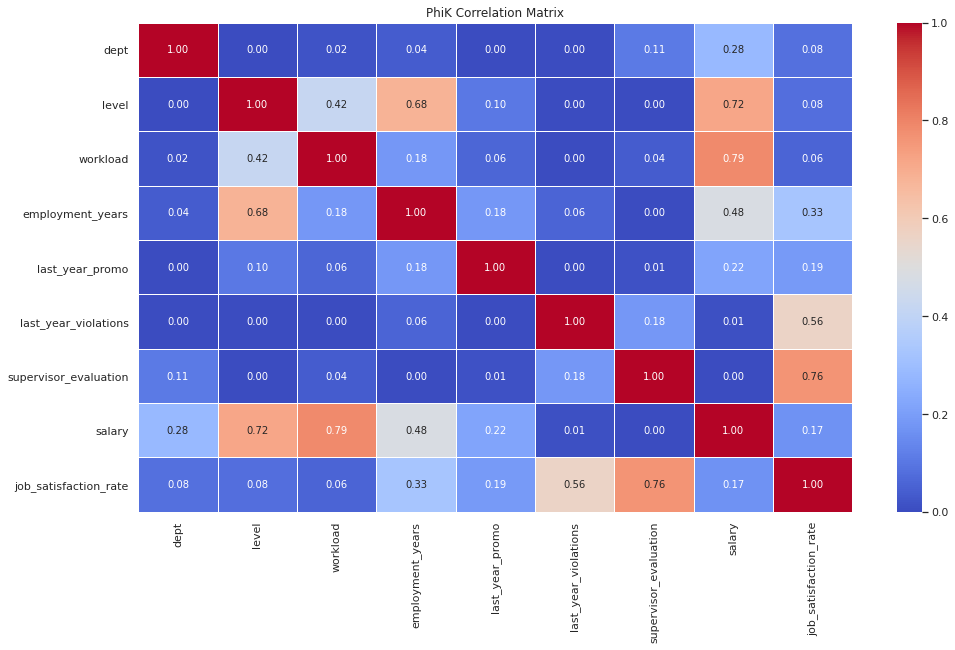

In [21]:
corr_matrix = train_data.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PhiK Correlation Matrix')
plt.show();

Какие выводы можно сделать по этой тепловой карте:
    
- *supervisor_evaluation* имеет выскоую корреляцию с целевой переменной
- *last_year_violations* тоже влияет на таргет но на среднем уровне
- *employment_years* хоть и коррелирует с *job_satisfaction_rate*, но слабо
- остальные признаки либо очень слабо, либо вообще никак не влияют на таргет
- также заметна корреляция между *salary* и *level*, *salary* и *workload*, *level* и *employment_years*
- оценка руководителя практически не зависит от остальных переменных

Проверим, нет ли существенных различий в данных между тренировочной и тестовой выборкой с помощью ещё одной тепловой карты

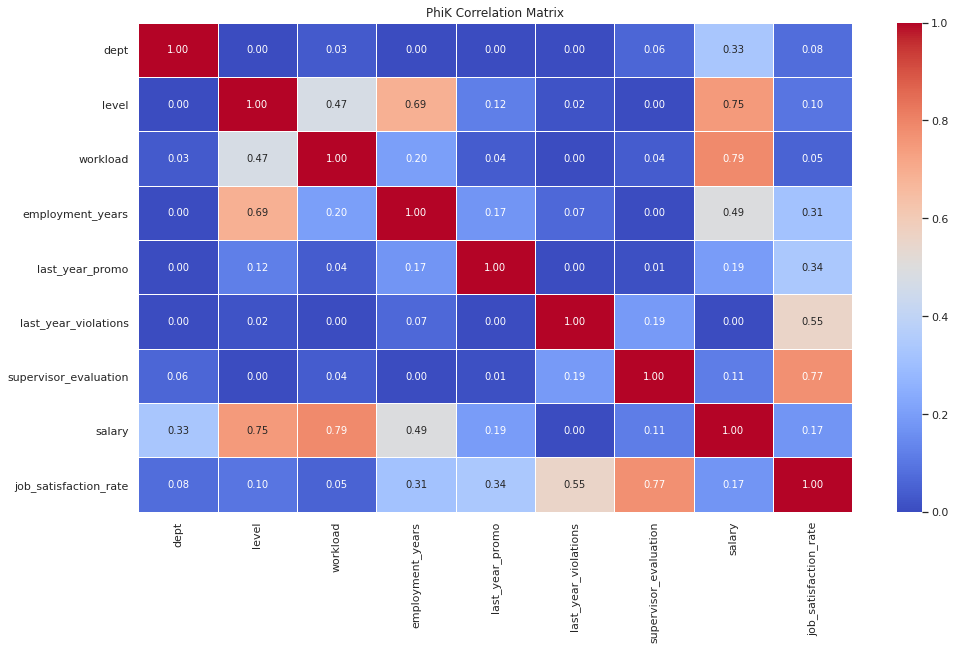

In [22]:
corr_matrix2 = test_data.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PhiK Correlation Matrix')
plt.show();

Единственное значимое отличие в корреляциях признаков тестовой и тренировочной выборках - увеличенное значение корреляции между *last_year_promo* и *job_satisfaction_rate*

Рассмотрим, как оценка сотрудника(*supervisor_evaluation*) зависит от *dept* и *last_year_violations* (остальные признаки никак не коррелируют с оценкой на тепловой карте)

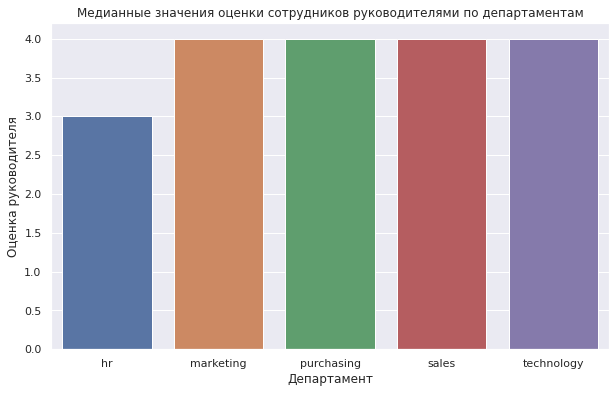

In [23]:
plt.figure(figsize=(10, 6))

sns.barplot(x='dept', y='supervisor_evaluation',
            data=train_data.groupby('dept')['supervisor_evaluation'].median().reset_index())

plt.title('Медианные значения оценки сотрудников руководителями по департаментам')
plt.xlabel('Департамент')
plt.ylabel('Оценка руководителя')
plt.show();

Этот график наводит на мысль, что в HR отделе более строго относятся к сотрудникам

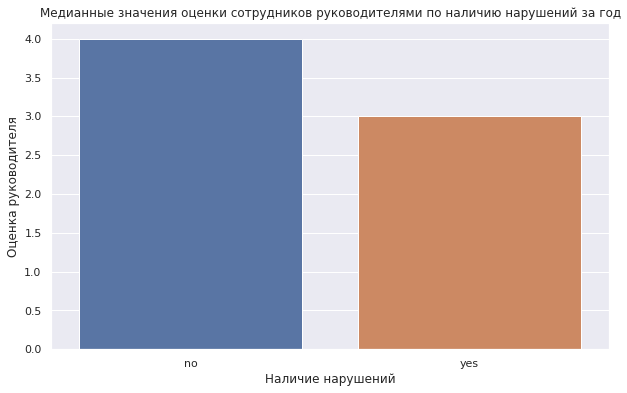

In [24]:
plt.figure(figsize=(10, 6))

sns.barplot(x='last_year_violations', y='supervisor_evaluation',
            data=train_data.groupby('last_year_violations')['supervisor_evaluation'].median().reset_index())

plt.title('Медианные значения оценки сотрудников руководителями по наличию нарушений за год')
plt.xlabel('Наличие нарушений')
plt.ylabel('Оценка руководителя')
plt.show();

Сотрудники, ненарушившие трудовой договор по праву получают более высокую оценку 

Теперь произведём подробный анализ зависимостей между будущими входными переменными и целевой(*job_satisfaction_rate*)

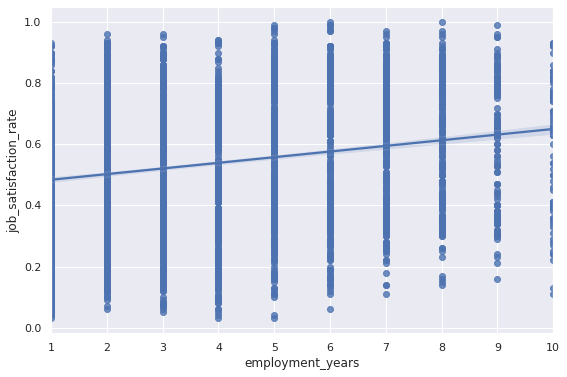

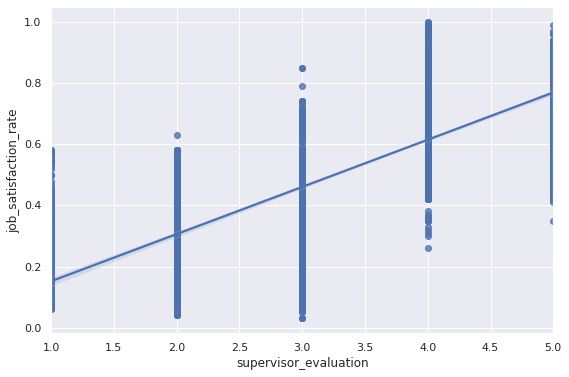

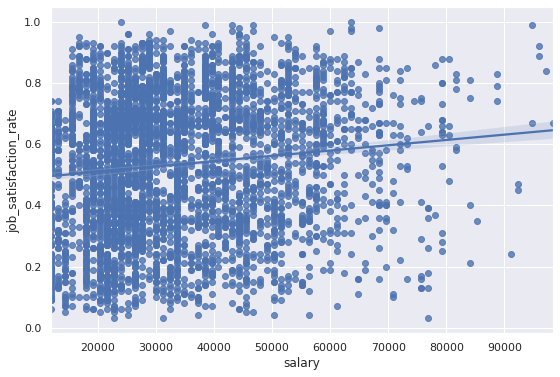

In [25]:
for col in train_data.select_dtypes(exclude='object').columns.drop('job_satisfaction_rate'):
    plt.figure(figsize=(9, 6))
    sns.regplot(data=train_data, x=col, y='job_satisfaction_rate')
    plt.show();

Как можно заметить, зависимость между количественными переменными и таргетом линейная

In [26]:
# функция, которая категоризирует зарплату
def salary_cat(salary):
    if salary < 30000:
        return 'Меньше 30к'
    elif 30000 <= salary < 60000:
        return 'от 30к до 60к'
    else:
        return 'больше 60к'
f_prep_data = train_data.copy()
f_prep_data['salary_cat'] = train_data['salary'].apply(salary_cat)

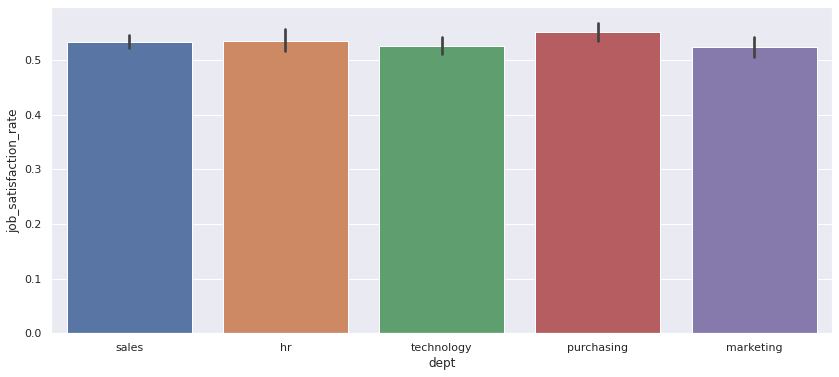

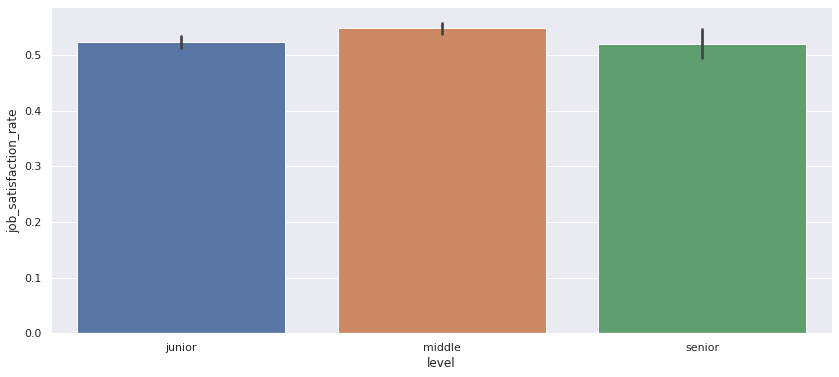

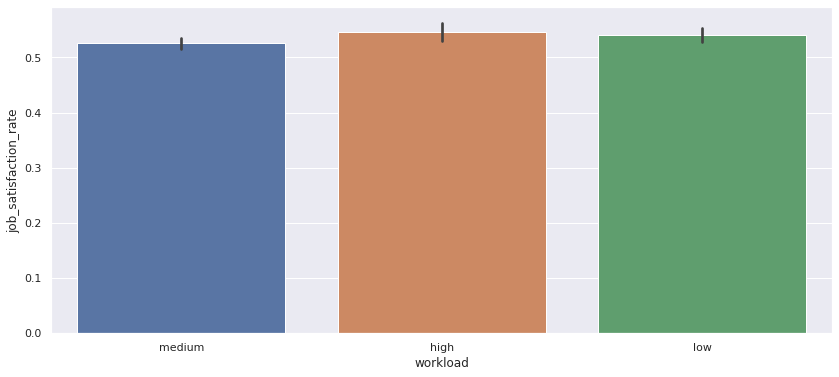

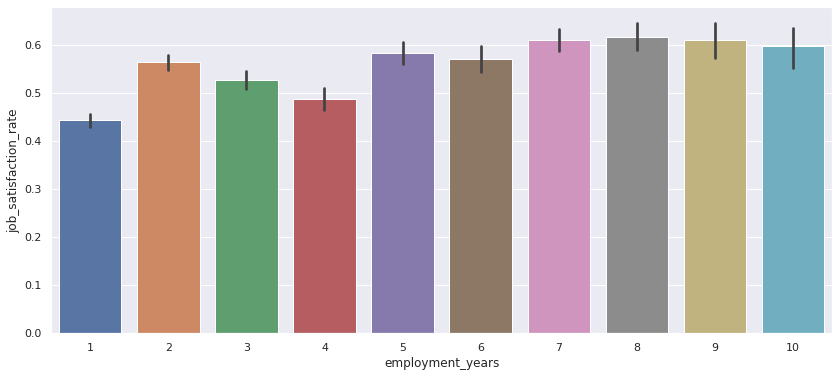

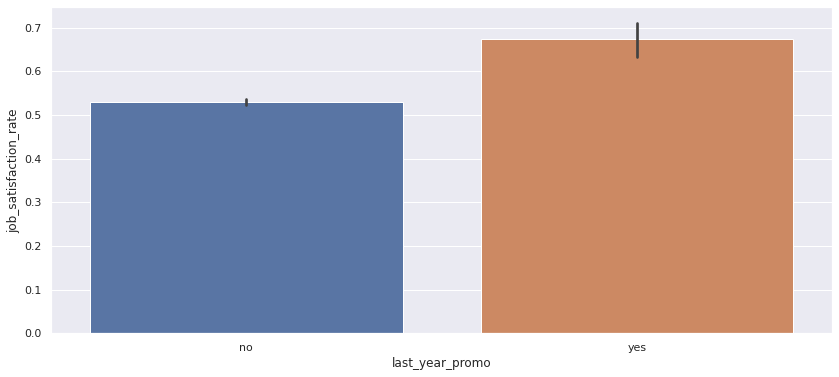

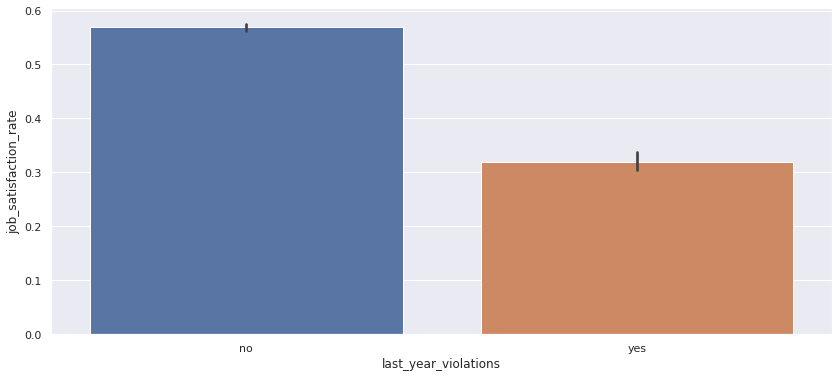

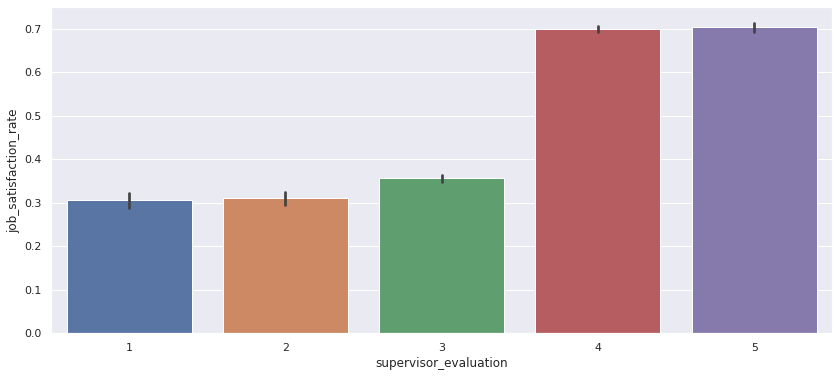

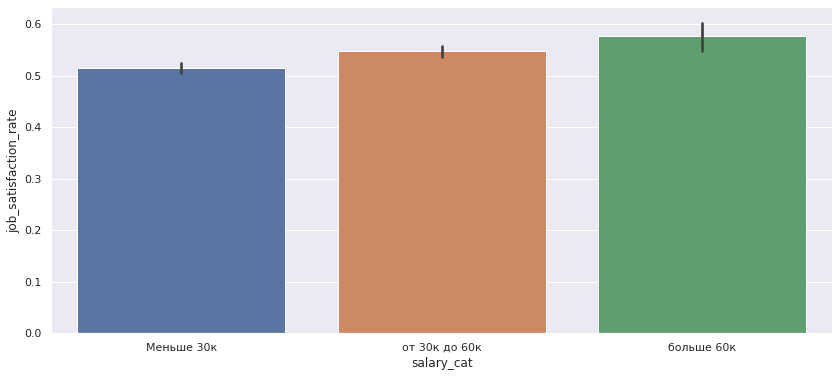

In [27]:
for col in f_prep_data.columns.drop(['job_satisfaction_rate', 'salary']):
    plt.figure(figsize=(14, 6))
    sns.barplot(data=f_prep_data, x=col, y='job_satisfaction_rate')
    plt.show();

- значение *dept*, *level*, *workload* практически не влияет на целевую переменную
- значение стажа работы(*employment_years*) всё же оказывает влияние не таргет: работники компании со стажем 1, 3 или 4 года имеюно заметно меньше удовлетворение работой
- налиичие повышения положительно влияет на *job_satisfaction_rate*
- существенное влияние оказывает наличие нарушений. Сотрудники с нарушениями имею очень низкую удовлетворённость работы
- также оценка руководителя взаимосвязана с таргетом: сотрудники с оценкой ниже 4-х имеют очень низкую удовлетворённость.(сотрудники с рейтингом 1 - 3, как и 4-5, имеют практически одинаковую удовлетворённость, так что можно выделить 2 группы оценок, которые будут характеризовать все 5)
- с ростом зарплаты растёт и удовлетворённость сотрудника

Можно сказать, что корреляция межжу категориальными перменными и таргетом, как и между числовыми и таргетом, преимущественно линейная. Так при увеличении категориального значния(в плане градации) увеличивается и удовлетворённость сотрудника

<a id="cor_an1"></a> 
**В результате корреляционного анализа было выявлено, что**:

- *supervisor_evaluation* имеет выскоую корреляцию с целевой переменной
- *last_year_violations* тоже влияет на таргет но на среднем уровне
- *employment_years* хоть и коррелирует с *job_satisfaction_rate*, но слабо
- остальные признаки либо очень слабо, либо вообще никак не влияют на таргет
- также заметна корреляция между *salary* и *level*, *salary* и *workload*, *level* и *employment_years*
- сотрудники HR-отдела получают в среднем меньшую оценку от руководителей, чем в остальных отделах
- наличие нарушений также влияет на оценку руководителя(*supervisor_evaluation*)
- корреляция между входными признаками и *job_satisfaction_rate* преимущественно линейная

<a id="t2_5"></a> 
### Подготовка данных

Для начала разделим тренировочные данные на входные и целевые

In [28]:
RANDOM_STATE=42

X_train = train_data.drop(['job_satisfaction_rate'], axis=1)
y_train = train_data['job_satisfaction_rate']

X_test = test_data.drop(['job_satisfaction_rate'], axis=1)
y_test = test_data['job_satisfaction_rate']

Как уже было сказано выше,
- *last_year_promo* и *last_year_volations* будут закодированы через OHE
- остальные категориальные переменные пройдут через OrdinalEncoder
- а числовые призноки будут стандартизированы черезе StandardScaler

In [29]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']
num_columns = X_train.select_dtypes(exclude='object').columns

Создадим пайплайны для подготовки категориальных признаков. Также не забудем про пропущенные значения и импутирем их с помощью SimpleImputer

In [30]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
)

In [31]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
             categories=[
                 ['junior', 'middle', 'senior'],
                 ['low', 'medium', 'high']
                        ]
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Оверсэмплинг для данных с непрерывным таргетом тяжело реализуем

Создадим общий пайплайн, который будет подготавливать наши данные

In [32]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

<a id="podg1"></a> 
**В ходе подготовки данных:**

- тренировочные данные были разделены на входные(X) и целевые(y)
- был создан пайплайн(data_preprocessor), который будет подготавливать данные для модели МО

<a id="t2_6"></a> 
### Обучение моделей

Так как мы предсказываем *job_satisfaction_rate*, то есть рейтинг - непрерывное значение от 0.00 до 1.00, мы решаем задачу регрессии. 

Из ранее изученных моделей нам подходят линейная регрессия(LinearRegression)(так как зависимость между переменными и таргетом преимущественно линейная) и деревья решений(DecisonTreeRegressor)(может моделировать сложные взаимодействия между признаками). 

Для проверки качества моделей будем использовать метрику SMAPE. Однако её нет в sklearn, так что придётся делать её самому

In [33]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    
    diff[denominator == 0] = 0
    
    return np.mean(diff) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

Готово, теперь определяем модели и их параметры, а затем прогоняем их через кроссвалидацию

In [34]:
lr_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('lr', LinearRegression())
])

У LinearRegression очень мало гиперпараметров, поэтому просто измерим SMAPE модели через кроссвалидацию

In [35]:
-cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring=smape_scorer).mean()

25.028454946207077

Метрика говорит нам о том, что средняя ошибка между истинными и предсказанными значениями составляет 25%. То есть, в среднем, предсказания отклоняются от реальных значений на 25%.

Теперь посмотрим, какого результата добьётся дерево решений

In [36]:
dtree_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('dtree', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

У дерева решения уже можно настраивать гиперпараметры, так что укажем их

In [37]:
dtree_params = {
    'dtree__min_samples_leaf': range(1, 3),
    'dtree__min_samples_split': range(6, 10, 2),
    'dtree__max_depth':range(16, 22, 2),
    'dtree__max_features': range(8, 20, 2),#['auto', 'sqrt', 'log2'],
    'dtree__criterion': ['friedman_mse', 'poisson']
}

Проведём кроссвалидацию через GridSearchCV

In [38]:
dtree_search = GridSearchCV(
    dtree_pipe,
    dtree_params,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)

dtree_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', dtree_search.best_estimator_)
print('Метрика модели, полученная через кросс-валидацию:', -dtree_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                  

In [39]:
dtree_search.best_params_

{'dtree__criterion': 'friedman_mse',
 'dtree__max_depth': 20,
 'dtree__max_features': 10,
 'dtree__min_samples_leaf': 2,
 'dtree__min_samples_split': 8}

Отличный результат! Модель дерева решений значительно лучше обычной линейной регрессии. 14.42% отклонений от реальных значений - с этим можно работать

Сама модель: DecisionTreeRegressor(criterion='friedman_mse', max_depth=20,
                                       max_features=10, min_samples_split=8,
                                       max_features=10, min_samples_leaf=2, random_state=42)

Теперь рассчитаем SMAPE лучшей модели на тестовых данных

In [40]:
print('SMAPE модели дерева решений на тестовой выборке:', round(-smape_scorer(dtree_search, X_test, y_test), 2))

SMAPE модели дерева решений на тестовой выборке: 13.45


Значение метрики оказалось даже меньше, чем на кроссвалидационной выборке, а значит, модель не переобучилась

<a id="mod1"></a> 
**В результате обучения моделей**:

- сформирована метрика SMAPE для оценки качества моделей
- были использованы две модели регрессии: линейная и дерево решений
- лучшая модель была получена через алгоритм дерева решений. Её параметры: DecisionTreeRegressor(criterion='friedman_mse', max_depth=20, max_features=10, min_samples_split=8, max_features=10, min_samples_leaf=2, random_state=42)
- была получена метрика SMAPE = 13.45 на тестовых данных

<a id="imp_an1"></a> 
### Анализ важности признаков

Посмотрим, как распределялась важность признаков модели дерева решений с помощью SHAP-анализа

In [41]:
best_model = dtree_search.best_estimator_.named_steps['dtree']  
pipeline_features = dtree_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()   
X_ = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=pipeline_features)

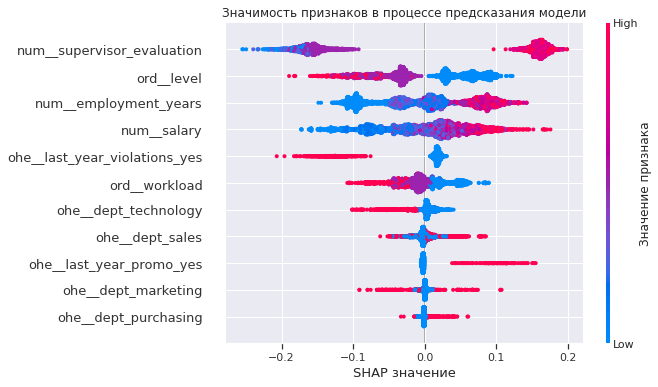

In [42]:
explainer = shap.TreeExplainer(best_model, X_)
shap_values = explainer(X_)

shap.plots.beeswarm(shap_values, max_display=100, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.set_xlabel("SHAP значение")
ax.set_title('Значимость признаков в процессе предсказания модели')

cb_ax = fig.axes[1] 
cb_ax.set_ylabel("Значение признака")

plt.show();

С точки зрения модели наиболее важными признаком для прогноза активности являются:

- supervisor_evaluation
- employment_years
- level
- salary(на предсказание таргета больше влияют слишком большие или слишком маленькие зарплаты)
- last_year_violatons

Что схоже с результатами нашего корреляционного анализа. 

<a id="bus1"></a> 
Что может сделать бизнес для увеличения удовлетворённости сотрудников:

- провести подробный анализ оценки руководителей(*supervisor_evaluation*) для выявления причин выставления тех или иных оценок
- удерживать сотрудников с большим стажем работы
- повышать слишком низкие зарплаты сотрудников
- следить за недопущением нарушений трудового договора

<a id="t2_8"></a> 
### Выводы о моделях

Почему же именно дерево решений показало себя хорошо, а линейная регрессия провалилась?

Наверное, самое очевидное - слабость самой модели. Линейная регрессия хорошо показывает себя на данных с чёткой зависимостью, однако в нашем датасете присутствуют и не такие уж и яркие корреляции. В то же время дерево решений может показывать неплохие результаты даже тогда, когда зависимость между переменными неочевидна

<a id="t3"></a> 
## Предсказание увольнения сотрудника из компании

<a id="t3_1"></a> 
### Загрузка данных

Загрузим новые данные и произведём из первичный осмотр

In [43]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [44]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [45]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Данные в таблице соответствуют описанию, пропусков нет

In [46]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [47]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Обнаружены пропуски в столбцах *dept* и *level*

In [48]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [49]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Пропусков нет, данные корректны

<a id="downl2"></a> 
**В результате загрузки и первичного осмотра данных**:

- было обнаружены пропущенные значения в таблице **test_features**
- опрделно, что признаки имеют корректные названия
- выявлено, что данные в таблицах соответствуют описанию

<a id="t3_2"></a> 
### Предобработка данных

Добавим в **test_quit** признак *quit* из **test_target_quit**

In [50]:
test_quit = test_features.merge(test_target_quit)

In [51]:
test_quit[test_quit['id'].isin(test_data.index)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes
1996,109582,technology,middle,low,3,no,no,2,21600,yes
1997,305653,technology,junior,low,1,no,no,3,14400,yes
1998,160233,technology,middle,low,8,no,no,1,32400,no


Тестовые данные двух задач  идентичны(2000 cтрок из 2000)

#### Обработка дубликатов

In [52]:
train_quit.drop('id', axis=1).duplicated().sum()

1413

Как мы уже говорили в первой задаче, дубликаты в тренировочной выборке никак не помешают работе модели МО, так что оставим их

Cделаем признак *id* индексом

In [53]:
train_quit.set_index('id', inplace=True)
test_quit.set_index('id', inplace=True)

Теперь посмотрим на наличие неявных дубликатов и некорректных значений

In [54]:
for col in train_quit.select_dtypes(include='object'):
    print(f' {col}: {train_quit[col].unique()}\n')

 dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']

 level: ['middle' 'junior' 'sinior']

 workload: ['high' 'medium' 'low']

 last_year_promo: ['no' 'yes']

 last_year_violations: ['no' 'yes']

 quit: ['no' 'yes']



In [55]:
for col in test_quit.select_dtypes(include='object'):
    print(f' {col}: {test_quit[col].unique()}\n')

 dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

 level: ['junior' 'middle' 'sinior' nan]

 workload: ['medium' 'low' 'high' ' ']

 last_year_promo: ['no' 'yes']

 last_year_violations: ['no' 'yes']

 quit: ['no' 'yes']



Точно такие же недочёты в тестовой выборке, как и в первой задаче:

- в dept есть значение ' '(пробел),
- в level некорректно записано значение 'sinior'(как и в тренировочной выборке),
- в workload присутствует значение ' '(пробел)

In [56]:
test_quit = test_quit[test_quit['dept'] != ' ']
test_quit = test_quit[test_quit['workload'] != ' ']
test_quit['level'].replace({'sinior': 'senior'}, inplace=True)
train_quit['level'].replace({'sinior': 'senior'}, inplace=True)

<a id="prep2"></a> 
**В результате предобработки данных**:

- в таблицу **test_quit** был добавлен столбец *quit* из **test_target_quit**
- обработаны некорректные значения

<a id="t3_3"></a> 
### Исследовательский анализ данных

<a id="t3_3_1"></a> 
#### Анализ распределения данных

Разделим признаки на количественные и категориальные

In [57]:
prep_quit_data_num_cols = ['salary']
prep_quit_data_obj_cols = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
                       'last_year_violations', 'supervisor_evaluation', 'quit']

Посмотрим на распределение данных в количественных и категориальных переменных на гистограммах

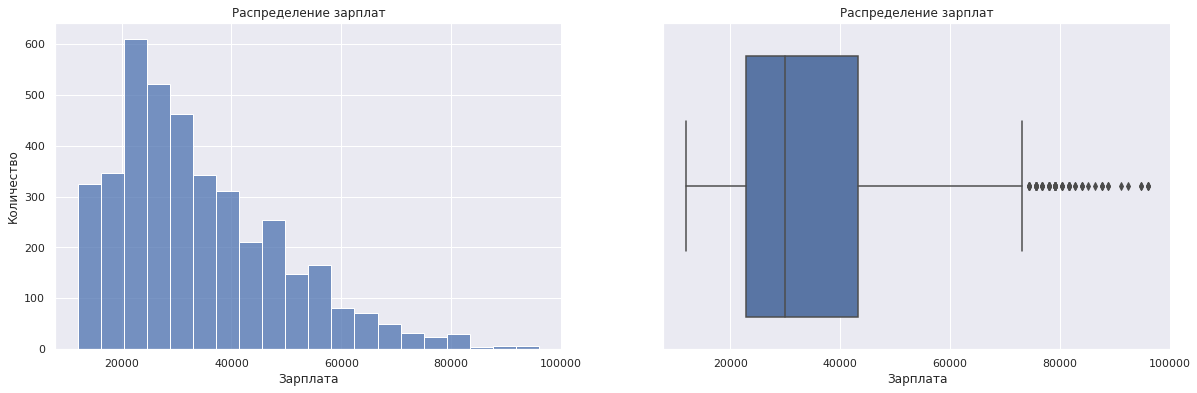

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# sns.histplot(data=prep_quit_data, x='employment_years', bins=10, discrete=True, ax=axs[0, 0])
# axs[0,0].set_xlabel('Длительность работы в компании')
# axs[0,0].set_ylabel('Количество')
# axs[0,0].set_title('Распределение длительности работы')

# sns.boxplot(prep_quit_data['employment_years'], orient='h', ax=axs[0, 1])
# axs[0,1].set_xlabel('Длительность работы в компании')
# axs[0,1].set_title('Распределение длительности работы')

# sns.histplot(data=prep_quit_data, x='supervisor_evaluation', discrete=True, ax=axs[1, 0])
# axs[1,0].set_xlabel('Оценка сотрудника, данная руководителем')
# axs[1,0].set_ylabel('Количество')
# axs[1,0].set_title('Распределение оценок сотрудников')

# sns.boxplot(prep_quit_data['supervisor_evaluation'], orient='h', ax=axs[1, 1])
# axs[1,1].set_xlabel('Оценка сотрудника, данная руководителем')
# axs[1,1].set_title('Распределение оценок сотрудников')

sns.histplot(data=train_quit, x='salary', bins=20, ax=axs[0])
axs[0].set_xlabel('Зарплата')
axs[0].set_ylabel('Количество')
axs[0].set_title('Распределение зарплат')

sns.boxplot(train_quit['salary'], orient='h', ax=axs[1])
axs[1].set_xlabel('Зарплата')
axs[1].set_title('Распределение зарплат')

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show();

- в количественных признаках отсутствуют аномальные значения,
- распределение значений преимущественно нормальное

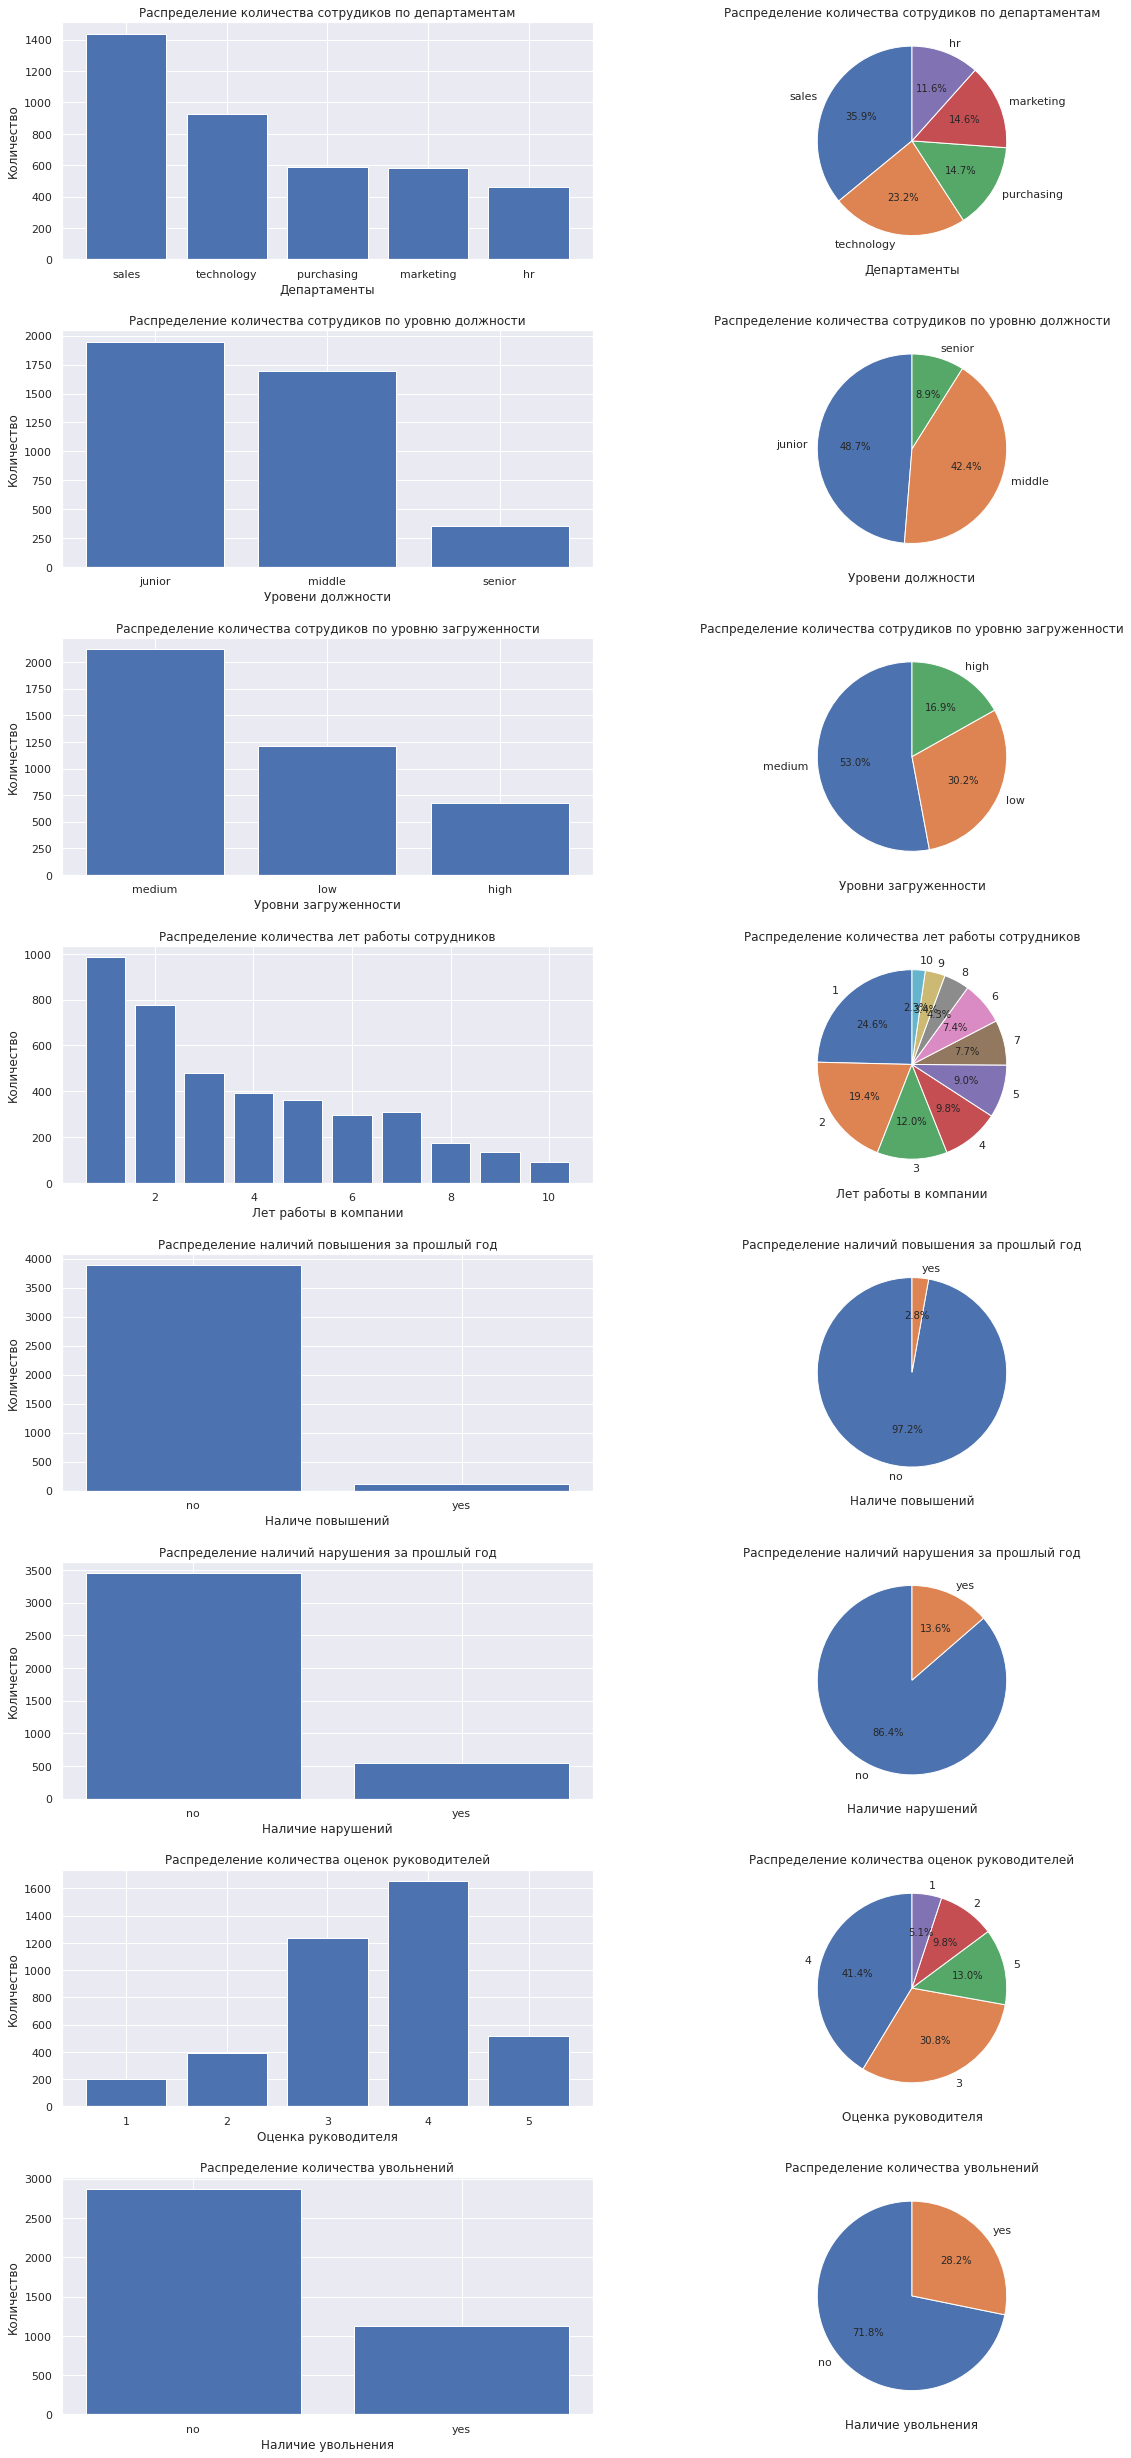

In [59]:
obj_pqdata_titles = [
    'Распределение количества сотрудиков по департаментам',
    'Распределение количества сотрудиков по уровню должности',
    'Распределение количества сотрудиков по уровню загруженности',
    'Распределение количества лет работы сотрудников',
    'Распределение наличий повышения за прошлый год',
    'Распределение наличий нарушения за прошлый год',
    'Распределение количества оценок руководителей',
    'Распределение количества увольнений'
]

obj_pqdata_xlabels = [
    'Департаменты',
    'Уровени должности',
    'Уровни загруженности',
    'Лет работы в компании',
    'Наличе повышений',
    'Наличие нарушений',
    'Оценка руководителя',
    'Наличие увольнения'
]

double_plots(train_quit, prep_quit_data_obj_cols, obj_pqdata_xlabels, obj_pqdata_titles, (20, 44))

Никакой значимой разницы между данными из первой задачи и второй нет. Все они не имеют выбросы и обладают нормальным распределением.

Можно выделить, что количество уволившихся сотрудников в 3 раза меньше количества оставшихся.

<a id="t3_3_2"></a> 
#### Портрет уволившегося сотрудника

Посмотрим, какими данными обладают уволившиеся сотрудники

In [60]:
quit_portrait_data = train_quit[train_quit['quit'] == 'yes']
nquit_portrait_data = train_quit[train_quit['quit'] == 'no']

Сначала рассмотрим характеристики уволившегося сотрудника по категориальным признакам

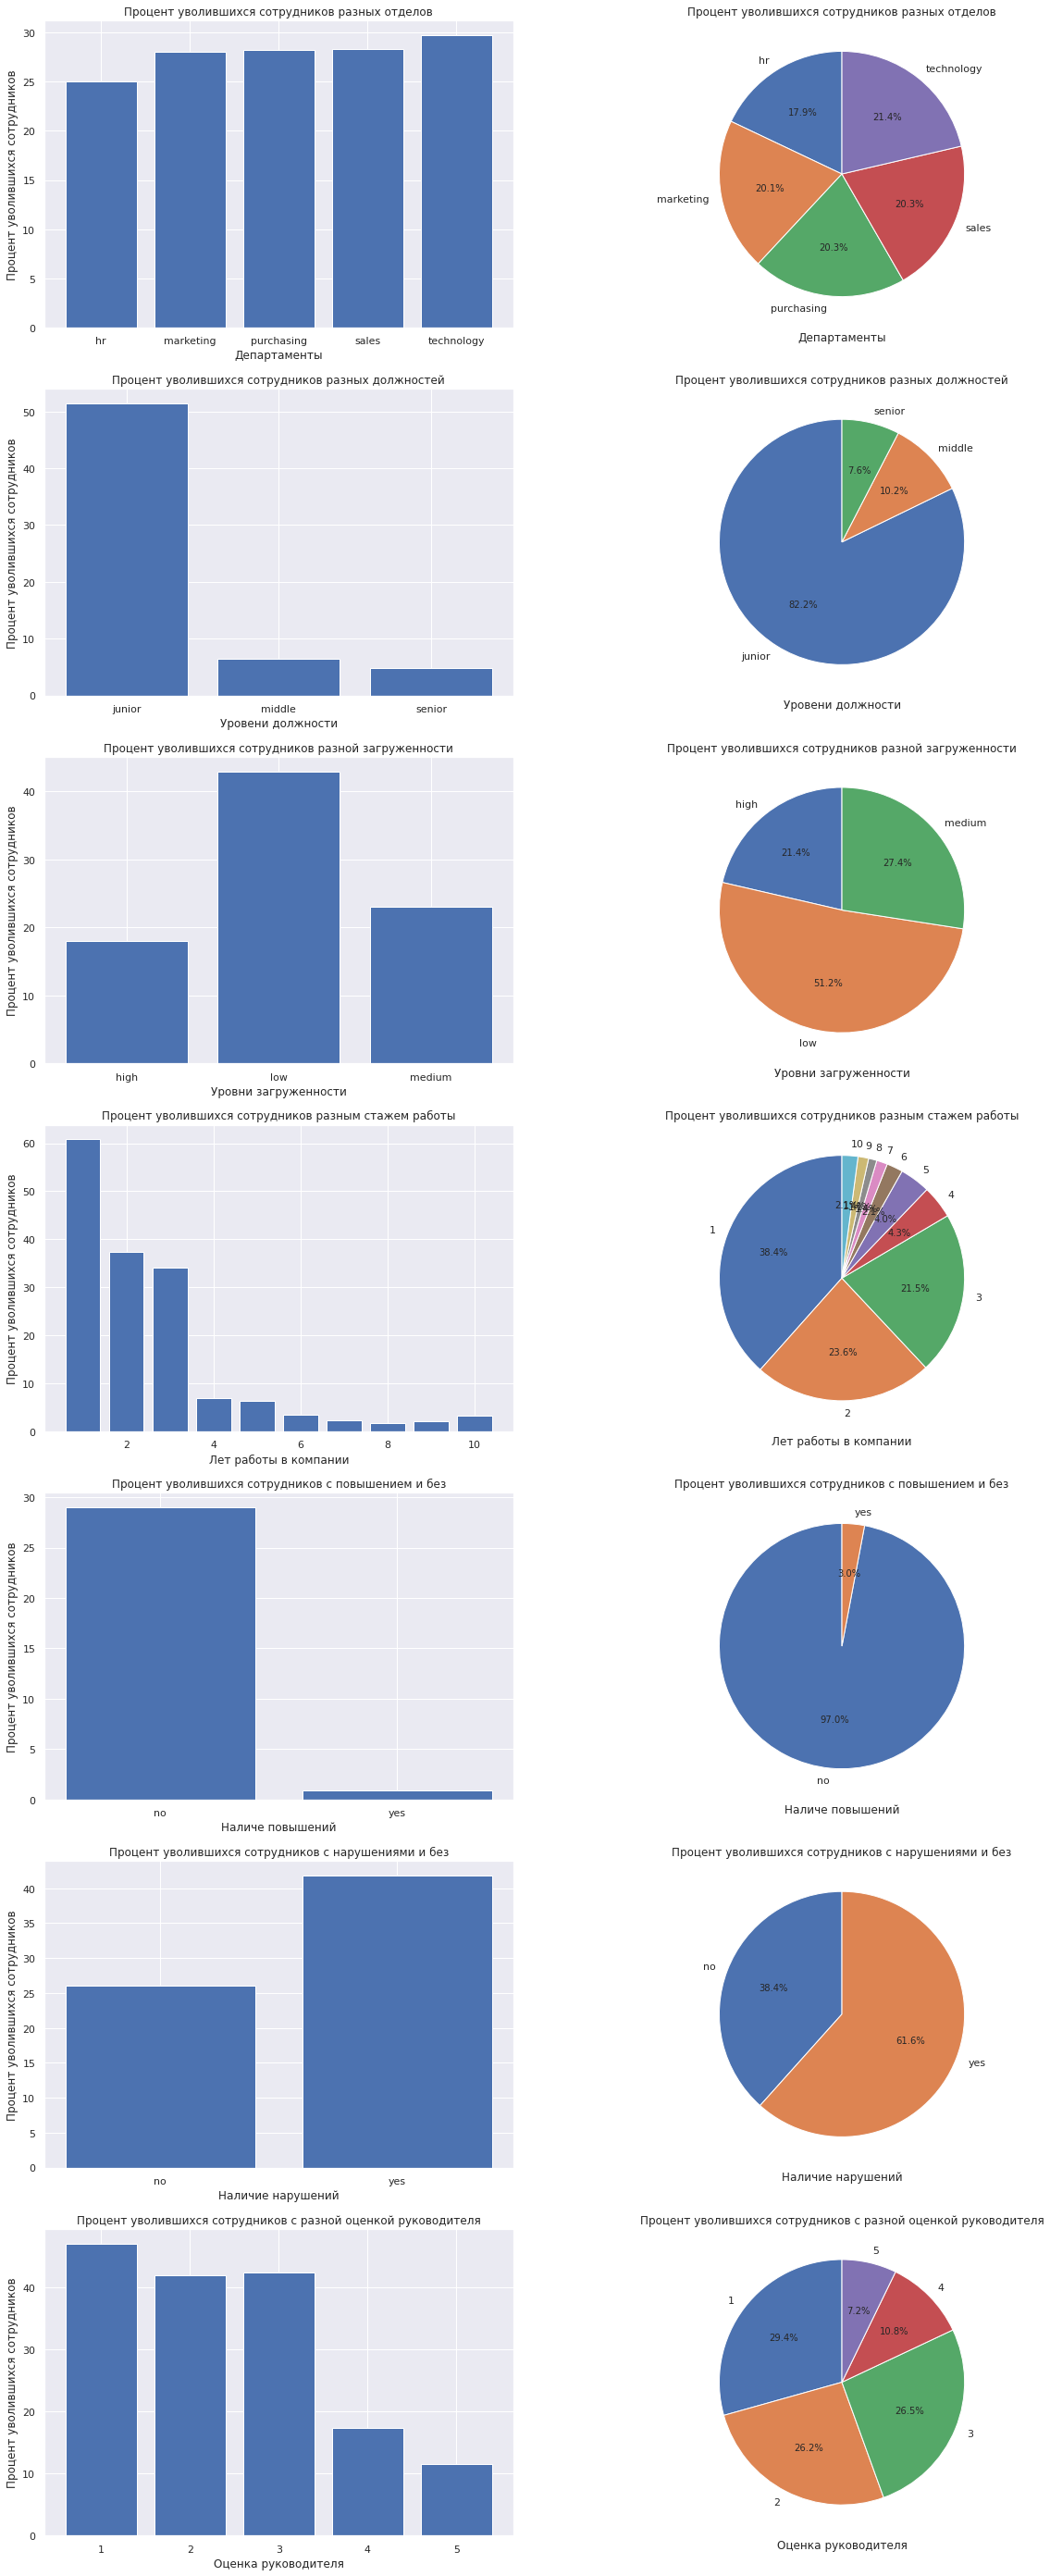

In [61]:
qxlabels = [
    'Департаменты',
    'Уровени должности',
    'Уровни загруженности',
    'Лет работы в компании',
    'Наличе повышений',
    'Наличие нарушений',
    'Оценка руководителя'
]

qtitles = [
    'Процент уволившихся сотрудников разных отделов',
    'Процент уволившихся сотрудников разных должностей',
    'Процент уволившихся сотрудников разной загруженности',
    'Процент уволившихся сотрудников разным стажем работы',
    'Процент уволившихся сотрудников c повышением и без',
    'Процент уволившихся сотрудников c нарушениями и без',
    'Процент уволившихся сотрудников c разной оценкой руководителя'
]

fig, axs = plt.subplots(7, 2, figsize=(20, 50))

for i in range(len(prep_quit_data_obj_cols)-1):
    col = prep_quit_data_obj_cols[i]
    xl = qxlabels[i]
    qt = qtitles[i]
    
    _data = (quit_portrait_data.groupby(col)[col].count()
         / train_quit.groupby(col)[col].count() * 100)
    
    axs[i, 0].bar(_data.index, _data)
    axs[i, 0].set_ylabel('Процент уволившихся сотрудников')
    axs[i, 0].set_xlabel(xl)
    axs[i, 0].set_title(qt)
        
    axs[i, 1].pie(_data, labels=_data.index, autopct='%1.1f%%', startangle=90)
    axs[i, 1].set_xlabel(xl)
    axs[i, 1].set_title(qt)    
plt.show();


Какие выводы можно сделать из этих графиков:

- в отделе закупок чаще, чем в других(на 2%) увольняются сотрудники
- большинство уволившихся сотрудников - junior специалисты
- в то же время middle и senior специалисты практически не покидают компанию
- половина уволившихся сотрудников имеет малую нагруженность
- зачастую увольняются сотрудники, чей стаж меньше 4 лет
- как правило(в 92% случаев) уволившийся сотрудник не имел повышения за последний год
- больше половины сотрудников, покинувших компанию были замечены в нарушениях
- большая часть(63%) суволившихся сотрудников имеют оценку руководителя меньше 4-х

Теперь посмотрим, чем отличаются уволившиеся сотрудники от тех, кто остаётся в компании, по числовым показателям

In [62]:
quit_portrait_data['salary'].mean()

23885.106382978724

In [63]:
nquit_portrait_data['salary'].mean()

37702.22841225627

Как можно заметить, уволившиеся сотрудники имеют гораздо меньшую зарплату

<a id="portrait"></a> 
Таким образом, мы можем сформировать "портрет уволившегося сотрудника":

Это junoir с малой загруженностью, у которого не было за год повышения, но он всё-таки успел нарушить трудовой договор; он работает в компании около двух лет, руководитель оценивает его как среднечка(оценка = 3), а его зарплата составляет в среднем 24000

<a id="t3_3_3"></a> 
#### Анализ влияния удовлетворённости сотрудника на его уход из компании

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: сравним распределения признака *job_satisfaction_rate* для ушедших и оставшихся сотрудников

Добавим к тестовым данным из первой задачи признак *quit*

In [64]:
test_data2 = test_data.join(test_target_quit.set_index('id'))

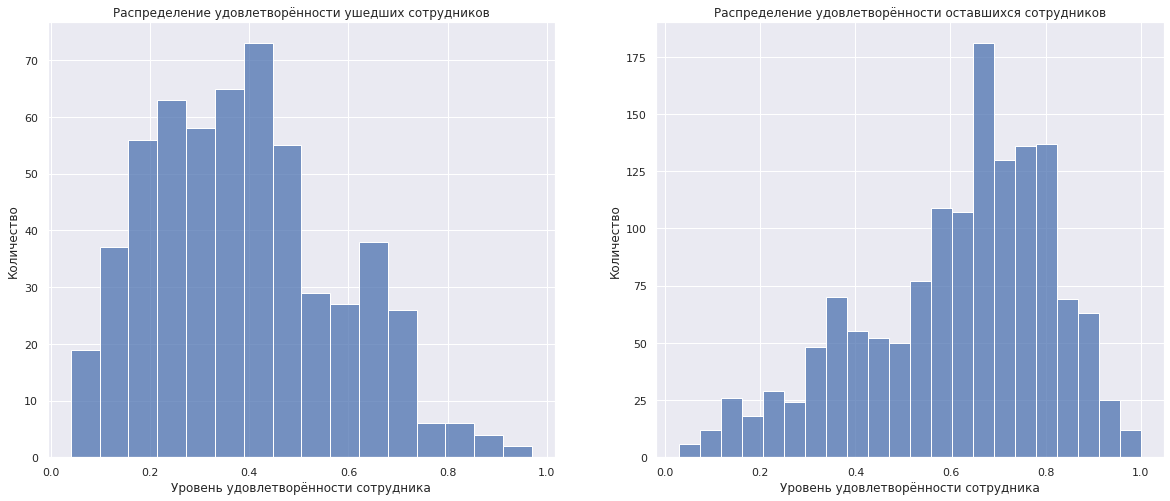

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=test_data2[test_data2['quit'] == 'yes'], x='job_satisfaction_rate', ax=axs[0])
axs[0].set_title('Распределение удовлетворённости ушедших сотрудников')
axs[0].set_xlabel('Уровень удовлетворённости сотрудника')
axs[0].set_ylabel('Количество')

sns.histplot(data=test_data2[test_data2['quit'] == 'no'], x='job_satisfaction_rate', ax=axs[1])
plt.title('Распределение удовлетворённости оставшихся сотрудников')
plt.xlabel('Уровень удовлетворённости сотрудника')
plt.ylabel('Количество')

plt.show();

По графикам видно, что большинство ушедших сотрудников имело *job_satisfaction_rate* меньше 0.5, в то время, как оставшиеся наоборот преимущественно имеют *job_satisfaction_rate* больше 0.5

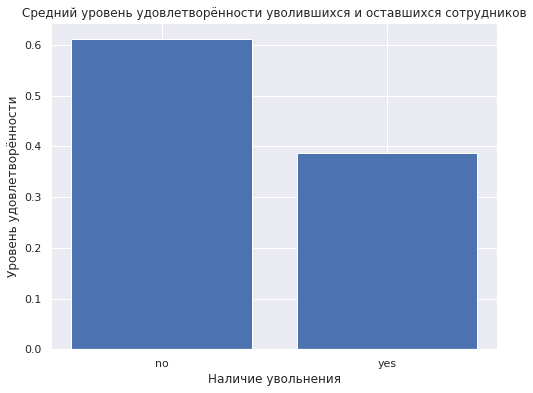

In [66]:
plt.figure(figsize=(8, 6))

_data = test_data2.groupby('quit')['job_satisfaction_rate'].mean()
plt.bar(_data.index, _data)
plt.title('Средний уровень удовлетворённости уволившихся и оставшихся сотрудников')
plt.xlabel('Наличие увольнения')
plt.ylabel('Уровень удовлетворённости')
plt.show();

Среднее значение удовлетворённости уволившихся сотрудников едва достигает 0.4, в то время, как у оставшихся он превышает 0.6


Диаграммы говорят нам о том, что предположение аналитиков верно: уровень удовлетворённости сотрудника работой в компании  действительно влияет на то, уволится ли сотрудник

<a id="an2"></a> 
**В ходе исследовательского анализа данных:**

- было проанализировано распределение данных(никаких выбросов или некорректностей найдено не было)
- был составлен "портрет" уволившегося сотрудника: это junoir с малой загруженностью, у которого не было за год повышения, но он всё-таки успел нарушить трудовой договор; он работает в компании около двух лет, руководитель оценивает его как среднечка(оценка = 3), а его зарплата составляет в среднем 26000
- было проверено утверждение аналитоков о том, что *job_satisfaction_rate* влияет на то, уволится ли сотрудник(действительно так и есть)

<a id="t3_4"></a> 
### Добавление нового входного признака

Как мы уже ранее выяснили, *job_satisfaction_rate* влияет на то, уволится ли сотрудник. Так почему бы нам не добавить предсказанные значения лучшей модели к нашим тренировочным данным для улучшения качества будщей модели

In [67]:
X_ = pd.DataFrame(data_preprocessor.fit_transform(train_quit.drop(['quit'], axis=1)),
                  columns=pipeline_features)
train_quit['job_satisfaction_rate'] = best_model.predict(X_)

В тестовой выборке(таблице test_data2) этот признак уже есть

<a id="t3_5"></a> 
### Подготовка данных

Подготовим признаки так же, как и в первой задаче

In [68]:
RANDOM_STATE=42

X_qtrain = train_quit.drop(['quit'], axis=1)
y_qtrain = train_quit['quit']

X_qtest = test_data2.drop(['quit'], axis=1)
y_qtest = test_data2['quit']

ohe_qcolumns = ['last_year_promo', 'last_year_violations', 'dept']
ord_qcolumns = ['level', 'workload']
num_qcolumns = X_qtrain.select_dtypes(exclude='object').columns

Закодируем целевой признак с помощью LabelEncoder

In [69]:
le = LabelEncoder()
le.classes_ = np.array(['no', 'yes'])

y_qtrain = le.transform(y_qtrain)
y_qtest = le.transform(y_qtest)

Сами пайпланы подготовки данных никак не изменились, лишь добавился количественный признак *job_satisfaction_rate*

In [70]:
data_preprocessor2 = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_qcolumns),
     ('ord', ord_pipe, ord_qcolumns),
     ('num', MinMaxScaler(), num_qcolumns)
    ], 
    remainder='passthrough'
)

Оверсемплинг не был задействован, так как без него модель даёт более высокие результаты

<a id="t3_6"></a> 
### Обучение модели

В этой задаче нам предлагают определить, уволится ли сотрудник. Всего есть 2 возможных значения, а значит, перед нами задача классификации

В качестве моделей возьмём:
- LogisticRegression(я всё ещё верю в то, что линейная зависимость присутствует)
- DecisionForestClassifier(именно дерево решений помогло нам определить *job_satisfaction_rate* сотрудников и очень даже неплохо справилось с этой задачей)
- KneighborClassifier(простая и интерпретируемая)

В качестве метрики будем использовать ROC-AUC, так как присутствует дисбаланс в распределении таргета. В дальнейшем можно узнать у компании, на чём следует сконцентрироваться: на точности или на общем количестве правильных предсказаний

Обучим модели, а потом определим лучшую из них на кроссвалидационной выборке

In [71]:
log_pipe = Pipeline([
    ('preprocessor2', data_preprocessor2),
    ('feature_selection', SelectKBest(score_func=f_classif, k=8)),
    ('log', LogisticRegression(random_state=RANDOM_STATE))
])

In [72]:
log_params = {
    'preprocessor2__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'], 
    'log__penalty': ['l1', 'l2', 'elasticnet'],
    'log__C':[0.2, 0.9, 1.3, 1.8, 2],
    'log__solver':['newton-cg', 'saga', 'liblinear'],
    'log__class_weight': ['None', 'balanced'],
    'log__tol': [1e-6, 1e-5, 1e-4]
}

In [73]:
log_search = RandomizedSearchCV(
    log_pipe,
    log_params,
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

log_search.fit(X_qtrain, y_qtrain)

print('Лучшая модель и её параметры:\n\n', log_search.best_estimator_)
print('Параметры модели', log_search.best_params_)
print ('Метрика модели на кроссвалидационной выборке:', log_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                 

И сразу отличный результат! Модель логистической регрессии показала результат в 0.917 roc_auc_score

In [74]:
ctree_pipe = Pipeline([
    ('preprocessor2', data_preprocessor2),
    ('ctree', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

ctree_params = {
    'preprocessor2__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'], 
    'ctree__min_samples_leaf': range(9, 15),
    'ctree__min_samples_split': range(4, 10),
    'ctree__max_depth':range(8, 12),
    'ctree__max_features': range(8, 20, 2),
    'ctree__criterion': ['log_loss', 'entropy', 'gini'],
    'ctree__max_leaf_nodes': range(18, 34, 2)
}

ctree_search = RandomizedSearchCV(
    ctree_pipe,
    ctree_params,
    cv=5,
    n_iter=100,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

ctree_search.fit(X_qtrain, y_qtrain)

print('Лучшая модель и её параметры:\n\n', ctree_search.best_estimator_)
print('Параметры модели', ctree_search.best_params_)
print ('Метрика модели на кроссвалидационной выборке:', ctree_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                 

Дерево решений, хоть и на чуть-чуть, но превзошло логистическую регрессию: roc_auc_score = 0.934

In [75]:
knc_pipe = Pipeline([
    ('preprocessor2', data_preprocessor2),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('knc', KNeighborsClassifier())
])

knc_params = {
    'preprocessor2__num':[StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    'knc__n_neighbors': range(10, 25),
    'knc__weights':['balanced', 'uniform'],
    'knc__metric':['manhattan', 'euclidean', 'chebyshev', 'minkowski']
}

knc_search = RandomizedSearchCV(
    knc_pipe,
    knc_params,
    cv=5,
    n_iter=30,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

knc_search.fit(X_qtrain, y_qtrain)

print('Лучшая модель и её параметры:\n\n', knc_search.best_estimator_)
print('Параметры модели', knc_search.best_params_)
print ('Метрика модели на кроссвалидационной выборке:', knc_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                 

KNeighborsClassifier оказался среднячком среди трёх моделей. roc_auc_score = 0.931

Таким образом, именно модель DecisionTreeClassifier(max_depth=9, max_features=14,
                                        max_leaf_nodes=32, min_samples_leaf=14,
                                        min_samples_split=6, ctree__criterion='gini',
                                        random_state=42) оказалась лучшей
                                        
Проверим её метрику на тестовых данных

In [76]:
predicted_probas = ctree_search.predict_proba(X_qtest)[:, 1]
print('ROC-AUC лучшей модели на тестовой выборке:', roc_auc_score(y_qtest, predicted_probas))

ROC-AUC лучшей модели на тестовой выборке: 0.9268172524151009


Модель добилась отличных результатов и на тестовой выборке

<a id="mod2"></a> 
**В ходе обучения моделей:**

- были обучены три модели: LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier
- получена лучшая модель: DecisionTreeClassifier(max_depth=9, max_features=14,max_leaf_nodes=32, min_samples_leaf=14, min_samples_split=6, ctree__criterion='gini', random_state=42)
- была проверена точность лучшей модели на тестовых данных: метрика ROC-AUC превысила 0.92

<a id="imp_an2"></a> 
### Анализ важности признаков

Посмотрим, какие признаки больше всего повлияли на решения модели

In [77]:
best_model2 = ctree_search.best_estimator_.named_steps['ctree']  
pipeline_features2 = ctree_search.best_estimator_.named_steps['preprocessor2'].get_feature_names_out()   
X_2 = pd.DataFrame(data_preprocessor2.fit_transform(X_qtrain), columns=pipeline_features2)

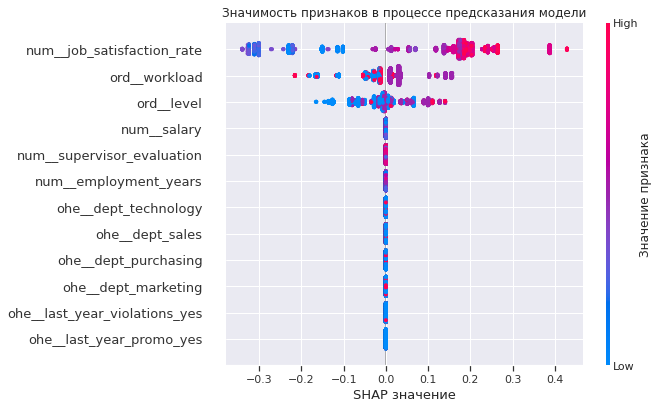

In [78]:
explainer2 = shap.TreeExplainer(best_model2, X_2)
shap_values2 = explainer2(X_2)
shap_values2 = shap_values2[:, :, 0]

shap.plots.beeswarm(shap_values2, max_display=100, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.set_xlabel("SHAP значение")
ax.set_title('Значимость признаков в процессе предсказания модели')

cb_ax = fig.axes[1] 
cb_ax.set_ylabel("Значение признака")

plt.show();

Какие признаки модель считает важными для прогноза увольнения сотрудника:

- *job_satisfaction_rate*
- *level*
- *workload*

Остальные признаки абсолютно никак не влияют на предсказания модели

<a id="bus2"></a> 
Из этого графика можно сделать вывод, что для уменьшения количества увольнений компании следует

- обращать внимание на *job_satisfaction_rate* сотрудников и стараться его повысить
- обеспечивать своих работников нагрузкой и проектами
- заботитья о том, чтобы в комании было больше 'middle' и 'senior' специалистов

### Выводы о моделях

На самом деле, трудно сказать, почему именно дерево решений лучше всех показало себя на данных. Каждая из моделей отличается от другой(по roc_auc_score) буквально на доли процентов.

Как уже говорилось ранее, дерево решений может хорошо моделировать как линейные, так и нелинейные зависимости. Кроме того, оно обладает возможностью настраивать огромное количество гиперпараметров, что позволяет чётко подстраивать модель под разные задачи

## Общий вывод

**Задача 1:**

Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

**Исходные данные:**([Подробнее](#t1))

- id — уникальный идентификатор сотрудника;

- dept — отдел, в котором работает сотрудник;

- level — уровень занимаемой должности;

- workload — уровень загруженности сотрудника;

- employment_years — длительность работы в компании (в годах);

- last_year_promo — показывает, было ли повышение за последний год;

- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

- salary — ежемесячная зарплата сотрудника;

- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании(целевой признак первой задачи);

**Проведённая предобработка:**([Подробнее](#t2_2))

- изменены некорректные значения

**В ходе исследовательского анализа данных:**([Подробнее](#t2_3))

- было графически представлено распределение данных([Подробнее](#an1))

**В результате корреляционного анализа**:([Подробнее](#cor_an1))

- были определены зависимости между разными признаками 

**В результате подготовки данных**([Подробнее](#podg1))

- был сформирован пайплайн, который будет подготавливать данные для модели

**В результате обучения моделей машинного обучения:**([Подробнее](#mod1))

- была получена лучшая модель, способная предсказать уровень удовлетворённости сотрудника (предсказания в среднем отклоняются на 13.5%)

**В ходе анализа важности признаков:**([Подробнее](#imp_an1))

- были определены ключевые в процессе принятия моделью решений признаки, а также представлены некоторые рекомендации для компании ([Подробнее](#bus1))



**Задача 2:**

Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Исходные данные:**

- id — уникальный идентификатор сотрудника;

- dept — отдел, в котором работает сотрудник;

- level — уровень занимаемой должности;

- workload — уровень загруженности сотрудника;

- employment_years — длительность работы в компании (в годах);

- last_year_promo — показывает, было ли повышение за последний год;

- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

- salary — ежемесячная зарплата сотрудника;

- quit — увольнение сотрудника из компании.

**Проведённая предобработка:**([Подробнее](#t3_2))

- изменены некорректные значения

**В ходе исследовательского анализа данных:**([Подробнее](#an2))

- было графически представлено распределение данных
- cформирован "портрет" уволившегося сотрудника([Подробнее](#portrait))
- произведён анализ влияния удовлетворённости сотрудника на его увольнение([Подробнее](#t_3_3))

**В процессе добавления нового входного признака**:([Подробнее](#t3_4))

- был добавлен новый признак(удовлетворённость сотрудника), основанный на предсказаниях модели из 1 задачи

**В результате подготовки данных**([Подробнее](#t3_5))

- был скопирован из 1 задачи и немного изменён пайплайн, который будет подготавливать данные для новой модели

**В результате обучения моделей машинного обучения:**([Подробнее](#mod2))

- была обучена модель, способная с большой точностью предсказать увольнение сотрудника

**В ходе анализа важности признаков:**([Подробнее](#imp_an2))

- были также определены ключевые в процессе принятия моделью решений признаки, а также представлены некоторые рекомендации для компании 



**Рекомендации для бизнеса**

Cледует:

- сконцентрироваться на факторах, которые повышают уровень оценки руководителя, и стараться повышать эти факторы(cкорее всего skill-ы) у сотрудников
- удерживать своих сотрудников, ведь чем больше стаж, тем меньше вероятность увольнения
- обращать внимание на удовлетворённость сотрудников и стараться её повысить
- обеспечивать своих работников нагрузкой и проектами